In [1]:
"""
In this nb, we are forecasting Time-Series with a Linear Regression Model and then with a bit more complex
model
"""

# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

In [2]:
# A function to plot time-series. This will be called finally when complete series is built
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end],series[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

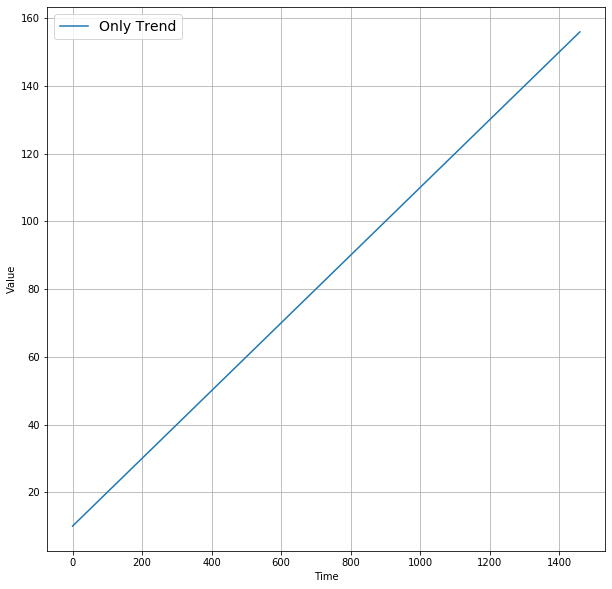

In [3]:
# Function to create a trend
def trend(time,slope=0):
    return slope*time

# Creating a time series which only has Trend for now
time = np.arange(4*365+1)
baseline = 10 #Base value for trend 
series = baseline + trend(time,0.1)

# Plotting the trend
plt.figure(figsize=(10,10))
plot_series(time,series,label="Only Trend")
# plt.show()

In [4]:
print(time,series)

[   0    1    2 ... 1458 1459 1460] [ 10.   10.1  10.2 ... 155.8 155.9 156. ]


In [5]:
# Function which creates a random pattern. This pattern will be repeated to get a seasonal pattern
def seasonal_pattern(seasonal_time):
    return np.where(seasonal_time < 0.4,
                    1/np.exp(3*seasonal_time),
                    np.cos(seasonal_time*2*np.pi))

# Function to repeat seasonal pattern
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

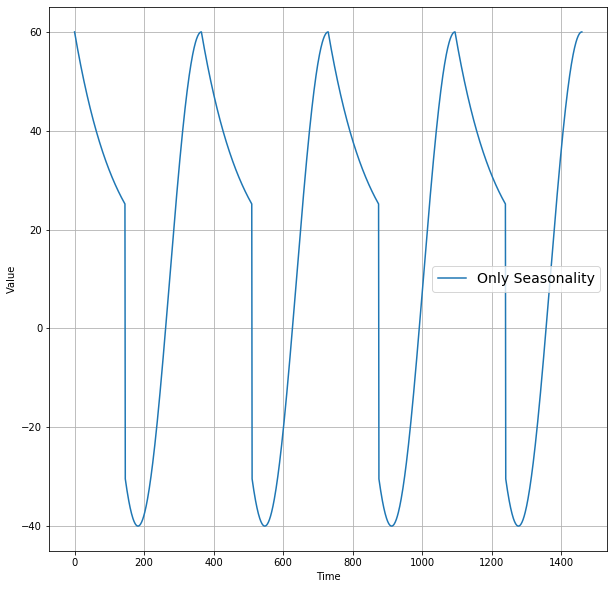

In [6]:
# Plotting Seasonality 
amplitude = 50
series = seasonality(time,period=365,amplitude=amplitude) + baseline
plt.figure(figsize=(10,10))
plot_series(time,series,label="Only Seasonality")

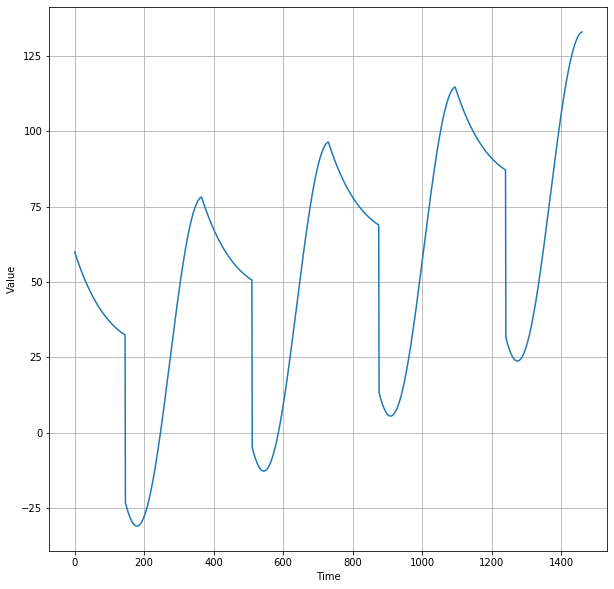

In [7]:
# Plotting seasonality with trend
slope = 0.05
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)
plt.figure(figsize=(10,10))
plot_series(time,series)

In [8]:
# Function to create white noise. seed parameter here is used by random number generator as a base to create
# random number. When it is None, rnd will use system time as seed. But, if we give some constant value like 42,
# then every time same noise will be generated. Thus, to get different noise everytime keep seed as None even 
# while calling the function
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

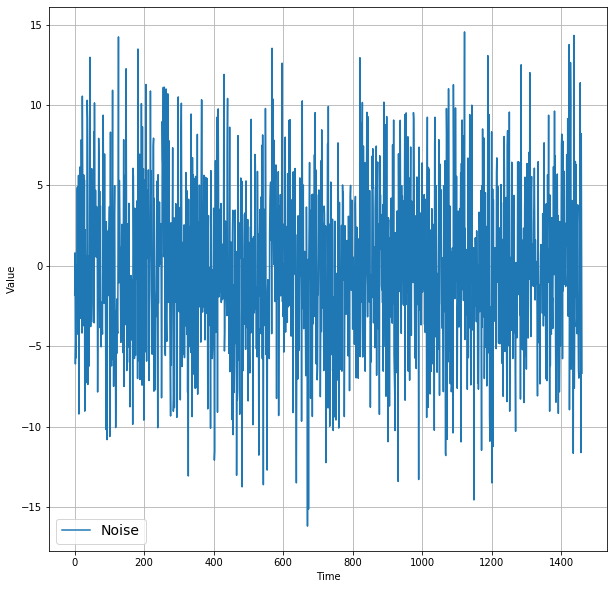

In [9]:
noise_level = 5
noise = white_noise(time,noise_level)
plt.figure(figsize=(10,10))
plot_series(time,noise,label="Noise")

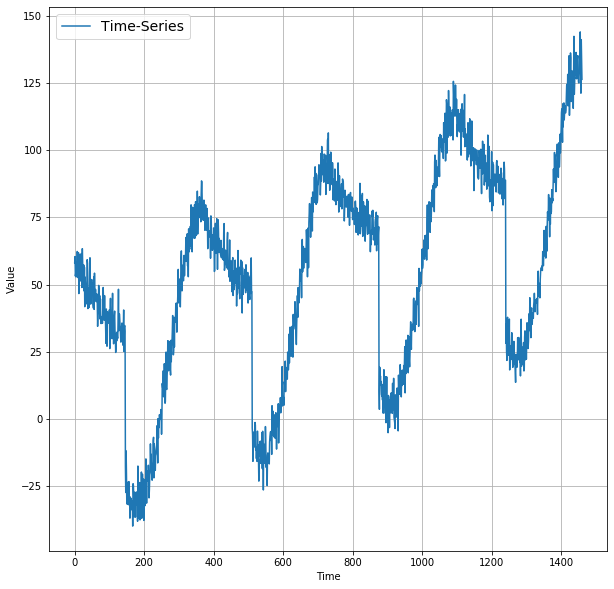

In [10]:
# Finally plotting complete time-series
series += noise
plt.figure(figsize=(10,10))
plot_series(time,series,label="Time-Series")

In [11]:
# In the Naive Forecasting, we just copy the previous value of time-series to the current time.
# For naive forecasting, split time-series into training and validation period. Splitting starts at 1000
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [21]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [18]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = tf.keras.Sequential([
    keras.layers.Dense(1,input_shape = [window_size])
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 30 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch/30))

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[lr_schedule])


Epoch 1/100
31/31 [==============================] - 1s 38ms/step - loss: 85.7925 - mae: 86.7164 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 71.1767 - mae: 70.1396 - val_loss: 112.3841 - val_mae: 112.6111
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 53.3688 - mae: 51.5673 - val_loss: 74.8938 - val_mae: 75.5733
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 34.0925 - mae: 32.8044 - val_loss: 38.5105 - val_mae: 39.0735
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 16.6327 - mae: 15.6655 - val_loss: 10.1759 - val_mae: 10.7264
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 10.3133 - mae: 10.6887 - val_loss: 9.7623 - val_mae: 10.2875
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 9.7978 - mae: 10.5949 - val_loss: 10.1949 - val_mae: 10.6171
Epoch 8/100
31/31 [=======================

31/31 [==============================] - 0s 12ms/step - loss: 6.5650 - mae: 6.8001 - val_loss: 4.7440 - val_mae: 5.2753
Epoch 63/100
31/31 [==============================] - 0s 12ms/step - loss: 5.0790 - mae: 5.5666 - val_loss: 5.7491 - val_mae: 6.1943
Epoch 64/100
31/31 [==============================] - 0s 13ms/step - loss: 5.5298 - mae: 5.8511 - val_loss: 5.8277 - val_mae: 6.3308
Epoch 65/100
31/31 [==============================] - 0s 12ms/step - loss: 4.9127 - mae: 5.4281 - val_loss: 12.3603 - val_mae: 12.9604
Epoch 66/100
31/31 [==============================] - 0s 12ms/step - loss: 5.6186 - mae: 5.9783 - val_loss: 5.1113 - val_mae: 5.6301
Epoch 67/100
31/31 [==============================] - 0s 12ms/step - loss: 5.1245 - mae: 5.5211 - val_loss: 4.9556 - val_mae: 5.4328
Epoch 68/100
31/31 [==============================] - 0s 12ms/step - loss: 8.8859 - mae: 9.6851 - val_loss: 4.8129 - val_mae: 5.2708
Epoch 69/100
31/31 [==============================] - 0s 12ms/step - loss: 5.441

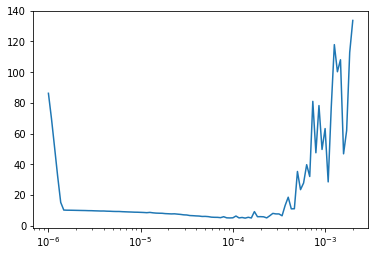

In [19]:
# Optimum value is 1e-5
plt.semilogx(history.history['lr'],history.history['loss'])

In [20]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = tf.keras.Sequential([
    keras.layers.Dense(1,input_shape = [window_size])
])

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

# EarlyStopping is used to avoid Overfitting. If best value of metric on validation set doesn't change for
# 10 epochs, Training is terminated. We can use more epochs if needed with this.
early_stopper = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper])

# MAE of almost 5.04 :)

Epoch 1/100
31/31 [==============================] - 1s 36ms/step - loss: 48.9073 - mae: 50.1014 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 13.2632 - mae: 13.1429 - val_loss: 11.7619 - val_mae: 12.4094
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 10.4896 - mae: 10.6109 - val_loss: 9.6651 - val_mae: 10.1149
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 9.9660 - mae: 10.1996 - val_loss: 9.1675 - val_mae: 9.6124
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 9.1788 - mae: 10.0064 - val_loss: 9.2962 - val_mae: 9.8190
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 9.5223 - mae: 9.8460 - val_loss: 10.3916 - val_mae: 10.9264
Epoch 7/100
31/31 [==============================] - 0s 16ms/step - loss: 9.1071 - mae: 9.8336 - val_loss: 8.7868 - val_mae: 9.2075
Epoch 8/100
31/31 [==============================] - 0s

31/31 [==============================] - 0s 14ms/step - loss: 5.9320 - mae: 6.4559 - val_loss: 6.0741 - val_mae: 6.6092
Epoch 63/100
31/31 [==============================] - 0s 12ms/step - loss: 5.7778 - mae: 6.3793 - val_loss: 5.9370 - val_mae: 6.3608
Epoch 64/100
31/31 [==============================] - 0s 12ms/step - loss: 6.0381 - mae: 6.3113 - val_loss: 5.8363 - val_mae: 6.3338
Epoch 65/100
31/31 [==============================] - 0s 13ms/step - loss: 5.8203 - mae: 6.2563 - val_loss: 5.8202 - val_mae: 6.2662
Epoch 66/100
31/31 [==============================] - 1s 18ms/step - loss: 5.6752 - mae: 6.2507 - val_loss: 5.7676 - val_mae: 6.2212
Epoch 67/100
31/31 [==============================] - 0s 13ms/step - loss: 5.8236 - mae: 6.2544 - val_loss: 5.7384 - val_mae: 6.2081
Epoch 68/100
31/31 [==============================] - 0s 15ms/step - loss: 5.8240 - mae: 6.1744 - val_loss: 5.9682 - val_mae: 6.4312
Epoch 69/100
31/31 [==============================] - 0s 13ms/step - loss: 5.8955 

In [24]:
# Function to apply our model to series(This will be validation series)
def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [30]:
lin_forecast = model_forecast(model,series[split_time-window_size:-1],window_size)[:, 0]

In [31]:
lin_forecast.shape

(461,)

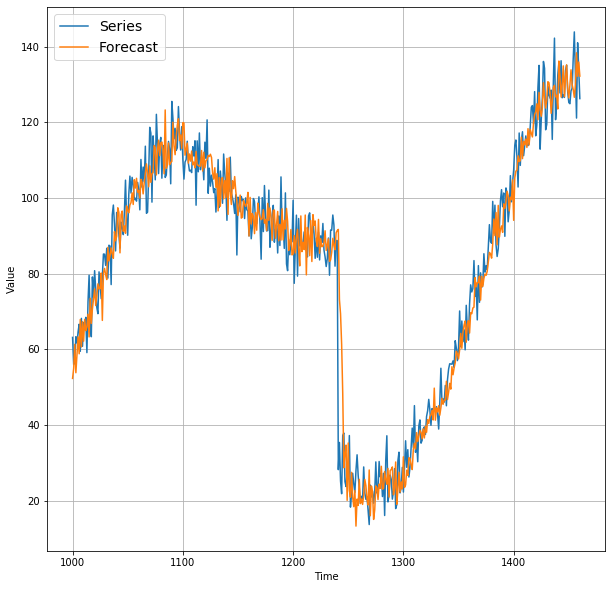

In [33]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,lin_forecast,label="Forecast")

In [36]:
keras.metrics.mean_absolute_error(lin_forecast,x_valid).numpy()

5.566318171697257

Epoch 1/100
31/31 [==============================] - 2s 52ms/step - loss: 43.1845 - mae: 43.7311 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 42.3925 - mae: 42.9752 - val_loss: 71.9270 - val_mae: 72.2552
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 41.6008 - mae: 42.0637 - val_loss: 69.4764 - val_mae: 70.1028
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 40.1885 - mae: 41.0298 - val_loss: 67.1955 - val_mae: 67.7456
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 40.0377 - mae: 39.8888 - val_loss: 64.9206 - val_mae: 65.0882
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 38.3511 - mae: 38.5988 - val_loss: 61.8199 - val_mae: 62.1486
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 36.5962 - mae: 37.1640 - val_loss: 58.4407 - val_mae: 58.8490
Epoch 8/100
31/31 [=======================

Epoch 62/100
31/31 [==============================] - 0s 15ms/step - loss: 5.9610 - mae: 6.5127 - val_loss: 7.5008 - val_mae: 7.9740
Epoch 63/100
31/31 [==============================] - 0s 14ms/step - loss: 6.2187 - mae: 6.6298 - val_loss: 7.3279 - val_mae: 7.7615
Epoch 64/100
31/31 [==============================] - 0s 13ms/step - loss: 5.2468 - mae: 5.6288 - val_loss: 5.7955 - val_mae: 6.1724
Epoch 65/100
31/31 [==============================] - 0s 12ms/step - loss: 5.6222 - mae: 6.1474 - val_loss: 5.5073 - val_mae: 6.0203
Epoch 66/100
31/31 [==============================] - 0s 13ms/step - loss: 5.1491 - mae: 5.6796 - val_loss: 6.4286 - val_mae: 7.0093
Epoch 67/100
31/31 [==============================] - 0s 13ms/step - loss: 5.3375 - mae: 5.8091 - val_loss: 6.9608 - val_mae: 7.4748
Epoch 68/100
31/31 [==============================] - 0s 16ms/step - loss: 6.0919 - mae: 6.6102 - val_loss: 6.0966 - val_mae: 6.5907
Epoch 69/100
31/31 [==============================] - 0s 14ms/step - 

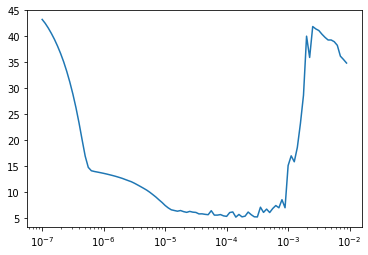

In [38]:
# Building the more complex model 
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = tf.keras.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape = [window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 20 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 ** (epoch/20))

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[lr_schedule])

# Optimum value is 1e-5 again
plt.semilogx(history.history['lr'],history.history['loss'])

In [40]:
# Building the more complex model 
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = tf.keras.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape = [window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

early_stopper = keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper])


Epoch 1/100
31/31 [==============================] - 1s 38ms/step - loss: 26.6381 - mae: 27.3369 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 14.4798 - mae: 14.4047 - val_loss: 8.3115 - val_mae: 8.9510
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 12.4382 - mae: 12.6955 - val_loss: 7.9739 - val_mae: 8.4545
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 11.6428 - mae: 11.8058 - val_loss: 7.4005 - val_mae: 7.9203
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 10.3798 - mae: 10.9290 - val_loss: 7.5638 - val_mae: 7.9733
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 9.9893 - mae: 10.1426 - val_loss: 7.4750 - val_mae: 8.0309
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 8.8693 - mae: 9.4914 - val_loss: 7.0754 - val_mae: 7.5802
Epoch 8/100
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 13ms/step - loss: 5.2643 - mae: 5.8163 - val_loss: 5.1336 - val_mae: 5.6635
Epoch 63/100
31/31 [==============================] - 0s 13ms/step - loss: 5.2141 - mae: 5.7836 - val_loss: 5.5115 - val_mae: 5.9107
Epoch 64/100
31/31 [==============================] - 0s 13ms/step - loss: 5.3245 - mae: 5.7673 - val_loss: 5.4441 - val_mae: 5.8913
Epoch 65/100
31/31 [==============================] - 0s 13ms/step - loss: 5.3603 - mae: 5.7614 - val_loss: 5.1412 - val_mae: 5.6541
Epoch 66/100
31/31 [==============================] - 0s 12ms/step - loss: 5.2366 - mae: 5.8111 - val_loss: 5.1955 - val_mae: 5.7155
Epoch 67/100
31/31 [==============================] - 0s 13ms/step - loss: 5.3312 - mae: 5.7327 - val_loss: 5.3929 - val_mae: 5.8526
Epoch 68/100
31/31 [==============================] - 0s 12ms/step - loss: 5.3995 - mae: 5.6823 - val_loss: 5.5564 - val_mae: 6.0608
Epoch 69/100
31/31 [==============================] - 0s 13ms/step - loss: 5.3171 

In [41]:
dense_forecast = model_forecast(model,series[split_time-window_size:-1],window_size)[:,0]

5.436513

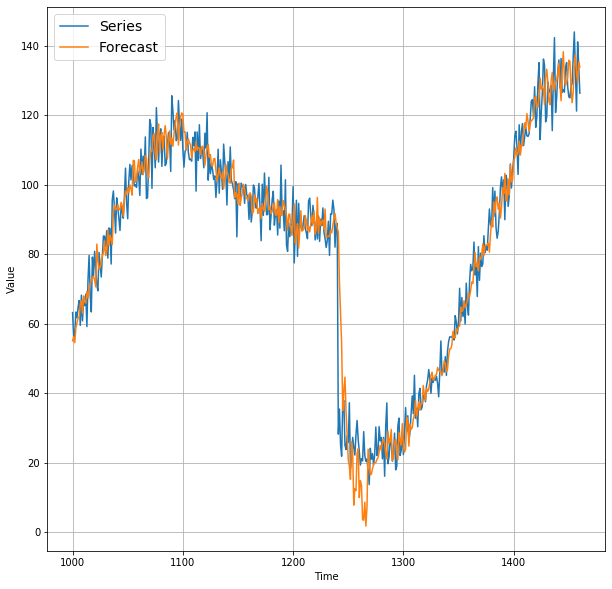

In [42]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,dense_forecast,label="Forecast")
keras.metrics.mean_absolute_error(x_valid,dense_forecast).numpy()